# Pre-requisites:
Please download this folder: https://drive.google.com/open?id=1xyssfNT-zIv7bN5jVhStAGzHLWj3FJSL

and put it in your main google drive. This is where some sample images are located and where the master keyword list is (for the OCR step)

You can rename it whatever you like, and put it wherever you like, but make sure the folder you downloaded is somewhere in your google drive! Then in the section under 'Python Globals', please set base_dir to point to whatever you renamed it to (if you didn't rename it and you put it in your main directory, then you don't need to do anything about that!)

In [96]:
# Mount drive code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
# Setup the environment
!sudo apt install tesseract-ocr

!pip install torch
!pip3 install torchvision
!pip install pytesseract
!pip install python-Levenshtein
!pip install munkres

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


# Python globals

In [0]:
# Python globals
base_dir = '/content/drive/My Drive/CSC420 Final Project'

# OCR and Post-processing steps

## Using Tesseract for Python
This part feeds the image into our OCR software (pytesseract in this case), gets the output, and does post-processing on it (removing bad text / lines, and creating key-value pairs using bipartite matching).

Please run the two code blocks below, as they handle definitions of the helper functions (and their dependencies)

In [0]:
# Helper functions!
from Levenshtein import distance
import numpy as np
from munkres import Munkres
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import re


def has_numbers(line):
    return bool(re.compile('\d').search(line))
    #return any(c.isdigit() for c in s)

def has_letters(line):
    return bool(re.compile('[a-zA-Z]').search(line))
    #return any(c.isalpha() for c in s)

def bipartite_match(pairs, keywords):
    # Use the Munkres library to utilize the Hungarian algorithm
    # to calculate the min distance matchings (for candidates and true keywords)
    munkres = Munkres()
    pairs = list(pairs)
    keywords = list(keywords)

    keywords_length = len(keywords)
    pairs_length = len(pairs)

    # Create distance map to feed into munkres.compute function
    distances = np.zeros((keywords_length, pairs_length)).astype(np.int32).tolist()
    for i in range(keywords_length):
        for j in range(pairs_length):
            candidate = pairs[j][0]
            distances[i][j] = distance(candidate, keywords[i])
    
    # Compute possible matchings, and then filter out the bad ones
    matchings = munkres.compute(distances)
    #print matchings

    good_pairs = []
    for i, j in matchings:
        keyword = keywords[i]
        distance_threshold = len(keyword) / 2
        if distances[i][j] < distance_threshold:
            # If matching is considered 'good' enough,
            # then we use it. Otherwise it is discarded
            good_pairs.append((keyword, pairs[j][1], pairs[j][2]))

    return good_pairs


# Second helper function block

In [0]:
# More helper functions. Please run this as well
def create_pairs(lines):
    pairs = []

    # Modify in place the lines
    # Get rid of empty lines
    lines = filter(None, lines)
    lines = filter(lambda line: line != ' ', lines)

    for i, line in enumerate(lines):
        # Skip the line if it doesn't seem like a good line
        if (len(line) <= 5 or (not has_numbers(line)) or (not has_letters(line))):
            continue

        # This step picks some possible candidate keywords.
        # They need to be at least as large as some threshold
        count_threshold = 3
        letter_count = 0

        for j in range(len(line)):
            if (has_letters(line[j])):
                letter_count += 1
            # Create the candidate keyword
            if (letter_count > count_threshold and has_numbers(line[j])): 
                before_space_index = j - 1
                # Likely will have a space, so remove it
                line = line[0 : before_space_index] \
                  + ' ' \
                  + line[j : len(line) - 1] 
                
                break

        # Look for a rough value string to go with the candidate keyword
        line_words = line.strip().split(' ')
        key, words = line_words[0], line_words[1:]

        for k, word in enumerate(words):
          # First occurence with a number is likely to be
          # a value (such as sodium amount, calorie content, etc)
            if has_numbers(word):
                words = words[k : ]
                break
            # If not a number, might be part of the nutrient keyword name
            # so add it to the candidate key
            else:
                key += ' ' + word
        
        # Rough value at best
        # TODO: clean-up further
        value = ('').join(words)
        pairs.append((key, value, i))

    # Cleanup step 1:
    # Remove obviously bad pairs created initially
    good_pairs = []

    # Cleanup the pairs we created by doing some Levenshtein
    # distance measurement betwen keywords and candidates to 
    # get rid of obvious non-keywords
    for pair in pairs:
        candidate_len = len(pair[0])
        is_good = False

        # Check part of the candidate using a window; if the distance is below
        # some threshold for some keyword, then it's probably a good candidate
        for key in keywords:
            key_len = len(key)
            window = candidate_len - len(key) + 1
            #print('Window:', window)
            #print(pair[0], key)
            if window <= 0:
                window = 1
            
            for i in range(window):
                threshold = key_len / 2 #key_len / 3

                dist = distance(key, pair[0][i : key_len + i - 1])

                if dist <= threshold:
                    is_good = True
                    break

        if is_good:
            good_pairs.append(pair)

    return good_pairs

# Handle matching keywords with candidate pairs
def match_pairs(pairs):
    new_keys = []

    for i, k in enumerate(pairs, 1):
        new_keys.append((k[0], k[1], i))

    key_pairs = bipartite_match(new_keys, keywords)

    # Check correct ordering. Remove candidates where the line # is too large
    # TODO: confirm where the bad index is coming from for File_002.png
    bad_indices = []

    for candidate in key_pairs:
        line_num = candidate[2]
        if line_num > len(key_pairs):
            #print(candidate)
            bad_indices.append(candidate[2])

    for i in bad_indices:
        for tup in new_keys:
            if i == tup[2]:
                new_keys.remove(tup) # Remove extraneous lines

    #print(bad_indices)

    # Too many lines, means we need to re-run the
    # matching again on the new, trimmed list of candidates
    if len(bad_indices) > 0:
        key_pairs = bipartite_match(new_keys, keywords)

    return key_pairs


def clean_values(tuples):
    # Gets rid of letters and non-numbers (excluding the period)
    # so we can convert to float later, for displaying
    # into a pie graph
    clean_tuples = []
    for tup in tuples:
        tup_copy = list(tup)
        value = tup_copy[1]
        value = re.sub('[^0-9.]', '', value)

        tup_copy[1] = value
        clean_tuples.append(tuple(tup_copy))

    return clean_tuples

# Creates the mapping we'll use to chart the pie graph
def post_process(ocr_text):
    # Create candidate key-value pairs
    lines = ocr_text.split('\n')
    candidate_pairs = create_pairs(lines)
    #print('Candidate pairs:\n', candidate_pairs)

    # Use bipartite matching to match each true keyword
    # to a candidate pair
    true_pairs = match_pairs(candidate_pairs)
    #print('True pairs:\n', true_pairs)

    # Perform final cleanup of the values in the key-value pairs
    cleaned = clean_values(true_pairs)
    #print('Cleaned up pairs:\n', cleaned)

    key_mapping = {}
    for p in cleaned:
      key_mapping[p[0]] = p[1]
    print('Final mapping:\n', key_mapping)

    return key_mapping

# Displaying the pie chart
If you run this cell, you should get a printout of the final detected nutrients and their values after postprocessing.

Alongside this, you will see a pie chart (which admittedly isn't displayed very well; something to put on the bucket list to fix). Below that you will see a picture of the food label it is based off of.

If you want to try different photos, please put them inside the <i> ${base_dir}/input_dataset </i> where base_dir is as as defined in the third code block. Then modify the image_path variable below to point to your image. 

Due to my post-processing step being not perfect, sometimes the code may bug out. I apologize for this. It currently works for certain with the stock image provided below.

Keywords loaded:
 {'calories': '', 'calories/calories': '', 'fat/lipides': '', 'fat': '', 'saturated/satures': '', 'saturated': '', 'trans/trans': '', 'carbohydrate': '', 'cholesterol': '', 'cholesterol/cholesterol': '', 'sodium/sodium': '', 'sodium': '', 'carbohydrate/glucides': '', 'fibre/fibres': '', 'fibre': '', 'fiber': '', 'dietary fiber': '', 'sugars/sucres': '', 'sugars': '', 'protein': '', 'total fat': '', 'total carbohydrate': ''}
Final mapping:
 {'calories': '80', 'fat/lipides': '9', 'saturated/satures': '1.5', 'trans/trans': '0', 'carbohydrate/glucides': '0'}


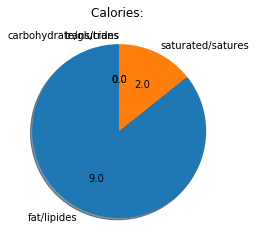

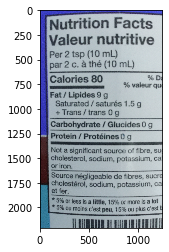

In [86]:
# OCR and Main post processing step
# The above two code cells need to be run first
# The two variables below can be modified to put in whatever you like to try.
nutrients_path = base_dir + '/na_nutrients.txt'
image_path = base_dir + '/input_dataset/File_002.png'

img = cv2.imread(image_path)

# Create a set of known nutrient keywords we're searching for
keywords = {}
nutrients_file = open(nutrients_path, 'r+')
for line in nutrients_file:
  keywords[line.strip()] = ""

print('Keywords loaded:\n', keywords)

# Post process
output_string = pytesseract.image_to_string(Image.open(image_path))
results = post_process(output_string)

# Display calories separately, not part of the pie chart
# Some hacky code...
calories = ''
if 'calories' in results or 'calories/calories' in results:
  results.pop('calories', None)
  results.pop('calories/calories', None)
if 'calories' in results:
  calories = results['calories']

if 'calories/calories' in results:
  calories = results['calories/calories']

keys = results.keys()
values = [float(results[k]) for k in keys]

# Credit for absolute_value function goes to ImportanceOfBeingErnest
# from StackOverFlow:
# https://stackoverflow.com/questions/41088236/how-to-have-actual-values-in-matplotlib-pie-chart-displayed-python
def absolute_value(val):
    a  = np.round(val/100 * sum(values), 0)
    return a

fig1 = plt.pie(values, labels=keys, shadow=True, autopct=absolute_value, startangle=90)
#plt.legend()
plt.title('Calories: ' + calories)

plt.show()
plt.imshow(img)

# Using CRNN
This part doesn't work properly. The code for the (attempted) implementation of the CRNN model in PyTorch is here, as mentioned in my report.

According to the paper I based it off of, it has seven convolutional layers, forming the CNN part of the network. Then the output of that is fed into a RNN, which is composed of two stacked bi-directional LSTMS. Those are output into a transcription layer, which we utilize a CTC to get the actual string output.

The alphabet I defined is below. So is the implementation of the CRNN in Pytorch

In [0]:
import torch.nn as nn


alphabet = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ/-"
# Heavily based on the architecture proposed in the paper:
# https://arxiv.org/pdf/1507.05717.pdf

# 
class BidirectionalLSTM(nn.Module):

    def __init__(self, in_d, hidden_d, out_d):
        super(BidirectionalLSTM, self).__init__()
        
    def forward(self, x):
        rec, _ = nn.LSTM(in_d, hidden_d, bidirectional=True)(x)
        channels, w, h = rec.size()

        out = nn.Linear(2 * hidden_d, out_d)(recurrent.view(channels*w, h))

        return out.view(channels, w, -1)


class CRNN(nn.Module):
 # I've added some batchNorms in some places to see
 # if it would help with the learning
    def __init__(self):
        super(CRNN, self).__init__()

        # 7 Convolution layers as defined in the paper
        # for the CNN part of CRNN
        # There's a helpful table (Table 1) in there on the 5th page
        # which summarizes the architecture of the network
        # https://arxiv.org/pdf/1507.05717.pdf
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) #stride = 2?
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 512, 2, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # RNN part (recurrent layer)
        self.rec = nn.Sequential(
            BidirectionalLSTM(512, 256, 256),
            BidirectionalLSTM(256, 256, len(alphabet) + 1)
        )
         # output: len(alphabet) + 1 different 'classes' (the alphabet being used)
         # + empty character

    def forward(self, x):
        # convolutional layer
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)

        # transform the output of CNN to fit the recurrent layer
        out = out.squeeze(2).permute(2, 0, 1)

        # recurrent layer
        return self.rec(out)


In [91]:
# Alphabet (characters we want to recognize in our nutrition labels)
print(len(alphabet) + 1)

65
